<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Ramki/E533_DLS_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

P1: Network Compression Using SVD

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train/=255
x_test/=255

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(10)
])

In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 10)                1

In [8]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics="acc")

In [9]:
history = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=128)

Epoch 1/30
469/469 [==============================] - 4s 4ms/step - loss: 0.2303 - acc: 0.9318
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1046 - acc: 0.9705
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0695 - acc: 0.9803
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0578 - acc: 0.9839
Epoch 5/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0516 - acc: 0.9851
Epoch 6/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0398 - acc: 0.9886
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0348 - acc: 0.9905
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0335 - acc: 0.9912
Epoch 9/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0297 - acc: 0.9919
Epoch 10/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0264 - acc: 0.9928
Epoch 11/30
469/469 [============================

In [10]:
def compress_weights(weight):
    S, U, V = tf.linalg.svd(weight)
    S = tf.linalg.diag(S)
    V = tf.transpose(V)
    return S,U,V

In [14]:
S_list = []
U_list = []
V_list = []
B_list = []
for i in range(1,6):
    weights = model.layers[i].weights[0]
    print(i,weights)
    bias = model.layers[i].bias.numpy()
    S,U,V = compress_weights(weights)
    S_list.append(S)
    U_list.append(U)
    V_list.append(V)
    B_list.append(bias)

1 <tf.Variable 'dense/kernel:0' shape=(784, 1024) dtype=float32, numpy=
array([[ 0.03753919, -0.01139279,  0.01196799, ...,  0.01106172,
         0.04881656, -0.04678631],
       [-0.0275651 ,  0.00599134,  0.02864742, ..., -0.0295137 ,
         0.00698932,  0.02618444],
       [-0.02193408,  0.05265652, -0.01907856, ...,  0.04458062,
        -0.00232806,  0.05337259],
       ...,
       [-0.04180066, -0.03109884,  0.02780601, ..., -0.00066502,
         0.02603488,  0.05364294],
       [-0.02639994, -0.0413323 , -0.04349478, ..., -0.05240909,
        -0.00122761,  0.01835021],
       [-0.03619152, -0.03463835,  0.04626844, ...,  0.00509717,
         0.0527067 ,  0.00057941]], dtype=float32)>
2 <tf.Variable 'dense_1/kernel:0' shape=(1024, 1024) dtype=float32, numpy=
array([[-0.03577313, -0.04209413,  0.03463709, ..., -0.02787228,
         0.05138737,  0.02797478],
       [ 0.03235637, -0.01469075, -0.11941659, ..., -0.14218466,
        -0.06206588,  0.066043  ],
       [-0.02617102,  0.

In [15]:
rank_values = [10,20,50,100,200]
acc_val = []
for value in rank_values:
    W_1 = tf.matmul(tf.matmul(U_list[0][:, :value], S_list[0][:value, :value]), V_list[0][:value, :])
    model.get_layer(index=1).set_weights([W_1,B_list[0]])
    W_2 = tf.matmul(tf.matmul(U_list[1][:, :value], S_list[1][:value, :value]), V_list[1][:value, :])
    model.get_layer(index=2).set_weights([W_2,B_list[1]])
    W_3 = tf.matmul(tf.matmul(U_list[2][:, :value], S_list[2][:value, :value]), V_list[2][:value, :])
    model.get_layer(index=3).set_weights([W_3,B_list[2]])
    W_4 = tf.matmul(tf.matmul(U_list[3][:, :value], S_list[3][:value, :value]), V_list[3][:value, :])
    model.get_layer(index=4).set_weights([W_4,B_list[3]])
    W_5 = tf.matmul(tf.matmul(U_list[4][:, :value], S_list[4][:value, :value]), V_list[4][:value, :])
    model.get_layer(index=5).set_weights([W_5,B_list[4]])
    acc_val.append(model.evaluate(x_test,y_test,verbose = 1)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1003 - acc: 0.9845


In [16]:
W_1 = tf.matmul(tf.matmul(U_list[0], S_list[0]), V_list[0])
W_2 = tf.matmul(tf.matmul(U_list[1], S_list[1]), V_list[1])
W_3 = tf.matmul(tf.matmul(U_list[2], S_list[2]), V_list[2])
W_4 = tf.matmul(tf.matmul(U_list[3], S_list[3]), V_list[3])
W_5 = tf.matmul(tf.matmul(U_list[4], S_list[4]), V_list[4])


model.get_layer(index=1).set_weights([W_1,B_list[0]])
model.get_layer(index=2).set_weights([W_2,B_list[1]])
model.get_layer(index=3).set_weights([W_3,B_list[2]])
model.get_layer(index=4).set_weights([W_4,B_list[3]])
model.get_layer(index=5).set_weights([W_5,B_list[4]])

acc_val.append(model.evaluate(x_test,y_test,verbose = 1)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1108 - acc: 0.9844


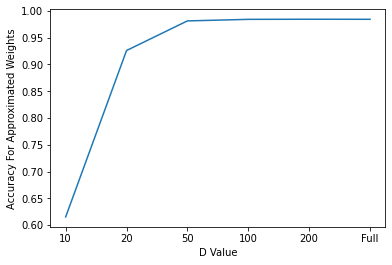

In [17]:
fig, ax = plt.subplots()
ax.plot(acc_val)
ax.set_ylabel("Accuracy For Approximated Weights")
ax.set_xlabel("D Value")
x = [0,10,20,50,100,200,'Full']
ax.set_xticklabels(x)
plt.show()

P4: Speaker Verification

In [ ]:
b